In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Parameters
simulations = 100000  # Number of simulations
years = 10               # Horizon
lambda_poisson = 0.138   # From IRIS report, loss likelihood (Poisson)
meanlog_impact = 12.55949 # From IRIS report, mean log impact (Log-Normal)
sdlog_impact = 3.068723   # From IRIS report, std log impact (Log-Normal)
discount_rate = 0.1     # Discount rate for NRV (Net Risk Value) calculations
control_cost = 50000     # Fixed mitigation cost of $50,000 per year when action is taken.

Simulates annual losses (projected_losses):
- Loss Event Frequency (lef_counts): loss events simulated as a Poisson process.
- Loss Magnitude (lm_impacts): Log-normal distribution reflects the heavy-tailed nature of impact data.

In [4]:
# Simulate losses 
lef_counts = np.random.poisson(lam=lambda_poisson, size=(simulations, years)) 
lm_impacts = np.random.lognormal(mean=meanlog_impact, sigma=sdlog_impact, size=(simulations, years))
projected_losses = lef_counts * lm_impacts

In [5]:
# Calculate mean projected losses over the horizon, representing the long-term average cost if no mitigation is applied.
# Oversimplification for comparison
expected_losses = np.mean(projected_losses, axis=1)

***
### Probabilistic Deciders
**Decision Rule:** Mitigate if expected loss exceeds mitigation cost.
***

In [6]:
# Probabilistic total costs
probabilistic_deciders = expected_losses > control_cost
probabilistic_deciders_costs = np.where(
    probabilistic_deciders.reshape(-1, 1),  # Decision to mitigate based on expected losses
    control_cost,                            # Cost of mitigation
    projected_losses                            # Cost of no mitigation
)

***
### Gut Feelers
**Decision Rule:** 
- High Likelihood/Impact Mitigation: Always mitigate for cases in the 90th percentile or higher for both likelihood and impact.
- Medium Likelihood/Impact: Randomly mitigate cases in the 50th-90th percentile range.
- Low Likelihood/Impact: Ignore events below the 50th percentile threshold.
***

In [7]:
# Define thresholds for high likelihood and high impact
high_likelihood_threshold = np.percentile(lef_counts, 90)  # Top 10% likelihood
medium_likelihood_threshold = np.percentile(lef_counts, 50)  # Top 50% likelihood

high_impact_threshold = np.percentile(lm_impacts, 90)  # Top 10% impact
medium_impact_threshold = np.percentile(lm_impacts, 50)  # Top 50% impact

# Heuristic-based decisions: Mitigate if both Likelihood and Impact are very high
gut_feelers = np.zeros_like(lef_counts, dtype=bool)

# Always mitigate for very high likelihood and impact (above 90th percentile)
very_high_criteria = (lef_counts > high_likelihood_threshold) & (lm_impacts > high_impact_threshold)
gut_feelers |= very_high_criteria

# Randomly choose for medium likelihood/impact (50th to 90th percentile)
medium_criteria = (
    (lef_counts > medium_likelihood_threshold) & (lef_counts <= high_likelihood_threshold) &
    (lm_impacts > medium_impact_threshold) & (lm_impacts <= high_impact_threshold)
)
random_choices = np.random.rand(*medium_criteria.shape) < 0.5  # Coin flip
gut_feelers |= (medium_criteria & random_choices)

# Always ignore below 50th percentile
low_criteria = (lef_counts <= medium_likelihood_threshold) | (lm_impacts <= medium_impact_threshold)
gut_feelers &= ~low_criteria

In [8]:
# Heuristic-based decisions
gut_feelers_costs = np.where(
    gut_feelers,                   # Decision to mitigate based on heuristic thresholds
    control_cost,                            # Cost of mitigation
    projected_losses                            # Cost of no mitigation
)

In [9]:
probabilistic_deciders_costs = probabilistic_deciders_costs.reshape(simulations, years)
gut_feelers_costs = gut_feelers_costs.reshape(simulations, years)

***
### Cost Discounting with DCF:

**Discounted Costs:** Future costs are discounted to present value using a 10% rate.

Discounted Cash Flow (DCF) is a financial valuation method used to estimate the value of an investment, asset, or project based on its expected future cash flows. The method involves discounting these future cash flows back to their present value using a discount rate, which accounts for the time value of money and risk.

Key Components of DCF:
- Future Cash Flows: The expected earnings or savings generated by the investment or project over a specified period.
- Discount Rate: Reflects the cost of capital, risk, or the opportunity cost of investing resources elsewhere. 
- Present Value: Future cash flows are discounted to reflect their value today, acknowledging that money now is worth more than the same amount in the future due to earning potential and inflation.

For our context, we'll adapt DCF to analyze the long-term financial impact of risk mitigation strategies. It helps in understanding the cost-effectiveness of mitigations by translating future losses or savings into today's monetary terms.

In [10]:
# Discount future costs
discount_factors = np.array([(1 + discount_rate) ** year for year in range(years)]).reshape(1, -1)

# Calculate discounted costs
discounted_probabilistic_deciders = np.sum(probabilistic_deciders_costs / discount_factors, axis=1)
discounted_gut_feelers = np.sum(gut_feelers_costs / discount_factors, axis=1)

In [11]:
# Verify
print("Discounted Probabilistic Deciders Costs:", discounted_probabilistic_deciders[:5])
print("Discounted Gut Feelers Costs:", discounted_gut_feelers[:5])

Discounted Probabilistic Deciders Costs: [   466.66996103 337951.19081376      0.              0.
 263503.74142875]
Discounted Gut Feelers Costs: [4.66669961e+02 2.56285627e+07 0.00000000e+00 0.00000000e+00
 4.54545455e+04]


These numbers represent the discounted costs for both the Probabilistic Deciders and Gut Feelers strategies, based on the simulated scenarios. 

- Variability in Costs: The costs across simulations are highly variable, reflecting the randomness of events (frequency and impact). Probabilistic Deciders show more stable costs compared to the extreme outliers in Gut Feelers (e.g., $25M in the second simulation).
- Effectiveness of Strategies: Probabilistic Deciders seem to mitigate risks effectively in high-loss scenarios (e.g., Simulation 2). Gut Feelers are inconsistent; while they sometimes incur lower costs (e.g., Simulation 5), they are vulnerable to outlier losses due to missed mitigations.

So far, this seems to support the idea that Probabilistic Deciders consistently manage risk better by aligning decisions with expected losses, whereas Gut Feelers are prone to extreme variations due to their heuristic approach.

In [12]:
# Compare mean NRV (Net Risk Value)
mean_probabilistic_deciders_nrv = np.mean(discounted_probabilistic_deciders)
mean_gut_feelers_nrv = np.mean(discounted_gut_feelers)

In [13]:
print(f"Probabilistic Deciders NRV: ${mean_probabilistic_deciders_nrv:.2f}")
print(f"Gut Feelers NRV: ${mean_gut_feelers_nrv:.2f}")

Probabilistic Deciders NRV: $177785.69
Gut Feelers NRV: $24659467.32


**Lower NRV for Probabilistic Deciders** means that this strategy is more cost-effective and robust over many simulations.

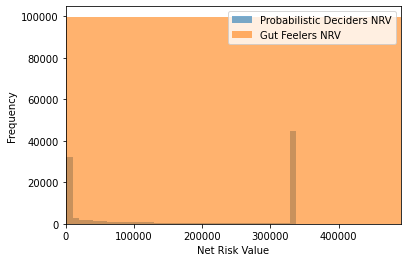

In [14]:
# Plot NRV distributions
plt.hist(discounted_probabilistic_deciders, bins=50, alpha=0.6, label="Probabilistic Deciders NRV")
plt.hist(discounted_gut_feelers, bins=50, alpha=0.6, label="Gut Feelers NRV")
# Restrict x-axis range for better visualization
plt.xlim(0, np.percentile(discounted_probabilistic_deciders, 99.99))  # Show up to 99.99th percentile
plt.xlabel("Net Risk Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

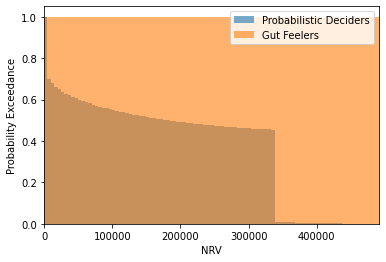

In [15]:
# Loss Exceedance Curves
plt.hist(discounted_probabilistic_deciders, bins=100, cumulative=-1, density=True, alpha=0.6, label="Probabilistic Deciders")
plt.hist(discounted_gut_feelers, bins=100, cumulative=-1, density=True, alpha=0.6, label="Gut Feelers")
# Restrict x-axis range for better visualization
plt.xlim(0, np.percentile(discounted_probabilistic_deciders, 99.99))  # Show up to 99.99th percentile
plt.xlabel("NRV")
plt.ylabel("Probability Exceedance")
plt.legend()
plt.show()

In [16]:
# Calculate cumulative discounted costs over time
cumulative_probabilistic_deciders = np.cumsum(probabilistic_deciders_costs / discount_factors, axis=1)
cumulative_gut_feelers = np.cumsum(gut_feelers_costs / discount_factors, axis=1)

# Calculate mean risk reduction across all simulations
mean_cumulative_probabilistic_deciders = np.mean(cumulative_probabilistic_deciders, axis=0)
mean_cumulative_gut_feelers = np.mean(cumulative_gut_feelers, axis=0)

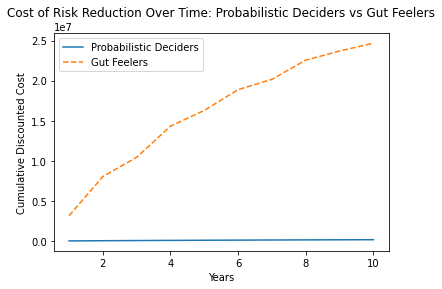

In [17]:
# Plot risk reduction over time
plt.plot(range(1, years + 1), mean_cumulative_probabilistic_deciders, label="Probabilistic Deciders")
plt.plot(range(1, years + 1), mean_cumulative_gut_feelers, label="Gut Feelers", linestyle="--")
plt.xlabel("Years")
plt.ylabel("Cumulative Discounted Cost")
plt.title("Cost of Risk Reduction Over Time: Probabilistic Deciders vs Gut Feelers")
plt.legend()
plt.show()

The gap between the two lines grows larger as time progresses, indicating that the inefficiency of Gut Feelers compounds over the 10 years.

In the long run, the Probabilistic Deciders have an advantage and maintain low cumulative costs, whereas Gut Feelers accumulate significantly higher costs due to the inconsistent and less-informed decisions.

Probabilistic Decision-Making is not only more sustainable, but also less costly over time.

In [18]:
# Calculate baseline losses (no mitigation)
baseline_losses = np.cumsum(projected_losses, axis=1)  # Cumulative losses without mitigation

In [19]:
# Calculate mitigated losses for probabilistic deciders
mitigated_probabilistic_deciders_losses = np.where(
    probabilistic_deciders.reshape(-1, 1),  # Mitigate if expected losses exceed control cost
    0.2 * projected_losses,  # Mitigated loss (assuming 80%  prevention)
    projected_losses  # No mitigation
)

In [20]:
cumulative_mitigated_probabilistic_deciders = np.cumsum(mitigated_probabilistic_deciders_losses, axis=1)

In [21]:
# Calculate mitigated losses for gut feelers
mitigated_gut_feelers_losses = np.where(
    gut_feelers,  # Mitigate if both likelihood and impact are high
    0.2 * projected_losses,  # Mitigated loss
    projected_losses  # No mitigation
)

In [22]:
cumulative_mitigated_gut_feelers = np.cumsum(mitigated_gut_feelers_losses, axis=1)

In [23]:
# Calculate risk reduction for each strategy
risk_reduction_probabilistic_deciders = baseline_losses - cumulative_mitigated_probabilistic_deciders
risk_reduction_gut_feelers = baseline_losses - cumulative_mitigated_gut_feelers

In [24]:
# Average risk reduction over simulations
mean_risk_reduction_probabilistic_deciders = np.mean(risk_reduction_probabilistic_deciders, axis=0)
mean_risk_reduction_gut_feelers = np.mean(risk_reduction_gut_feelers, axis=0)

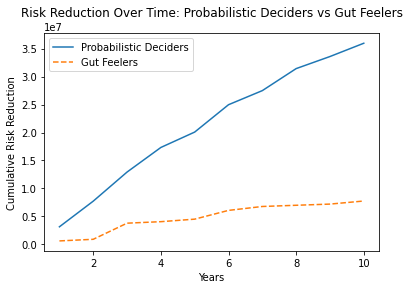

In [25]:
# Plot risk reduction over time
plt.plot(range(1, years + 1), mean_risk_reduction_probabilistic_deciders, label="Probabilistic Deciders")
plt.plot(range(1, years + 1), mean_risk_reduction_gut_feelers, label="Gut Feelers", linestyle="--")
plt.xlabel("Years")
plt.ylabel("Cumulative Risk Reduction")
plt.title("Risk Reduction Over Time: Probabilistic Deciders vs Gut Feelers")
plt.legend()
plt.show()

In [26]:
print(f"Probabilistic mitigations: {np.sum(probabilistic_deciders)}")
print(f"Gut Feelers mitigations: {np.sum(gut_feelers)}")
# Reshape probabilistic_deciders to match gut_feelers
probabilistic_deciders_reshaped = probabilistic_deciders.reshape(-1, 1)

# Calculate the overlap
overlapping_mitigations = np.sum(probabilistic_deciders_reshaped & gut_feelers)

print(f"Overlapping mitigations: {overlapping_mitigations}")

Probabilistic mitigations: 44547
Gut Feelers mitigations: 24875
Overlapping mitigations: 22825


There are of course both pros and cons with each approach:
- Risk of over-mitigation (Probabilistic Deciders): By mitigating more frequently, Probabilistic Deciders may have higher mitigation costs for risks that Gut Feelers would deem unnecessary.
- Risk of under-mitigation (Gut Feelers): By mitigating less frequently, Gut Feelers run the risk of leaving important risks unmitigated, which could lead to higher losses in unaddressed scenarios.

In [27]:
# Optionally calculate and display the percentage overlap
# Ensure probabilistic_deciders and gut_feelers have the same shape
probabilistic_deciders = probabilistic_deciders.reshape(-1, 1)  # Reshape to match the gut_feelers dimensions
gut_feelers = gut_feelers.astype(bool)  # Ensure boolean type
# Compare the arrays element-wise
overlap_decisions = (probabilistic_deciders == gut_feelers)
overlap_percentage = np.mean(overlap_decisions) * 100
print(f"Percentage of overlapping decisions: {overlap_percentage:.2f}%")

Percentage of overlapping decisions: 57.53%


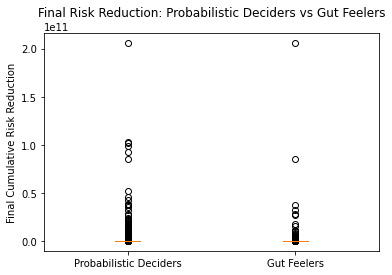

In [28]:
final_risk_reduction_probabilistic = risk_reduction_probabilistic_deciders[:, -1]
final_risk_reduction_gut_feelers = risk_reduction_gut_feelers[:, -1]

plt.boxplot(
    [final_risk_reduction_probabilistic, final_risk_reduction_gut_feelers],
    labels=["Probabilistic Deciders", "Gut Feelers"],
    patch_artist=True,
)
plt.ylabel("Final Cumulative Risk Reduction")
plt.title("Final Risk Reduction: Probabilistic Deciders vs Gut Feelers")
plt.show()

In [29]:
# Compare final risk reduction across all simulations
better_performance = final_risk_reduction_probabilistic > final_risk_reduction_gut_feelers
percentage_better = np.mean(better_performance) * 100

print(f"Probabilistic deciders outperformed gut feelers in {percentage_better:.2f}% of simulations.")

Probabilistic deciders outperformed gut feelers in 37.71% of simulations.


In [30]:
mean_probabilistic = np.mean(final_risk_reduction_probabilistic)
mean_gut_feelers = np.mean(final_risk_reduction_gut_feelers)

std_probabilistic = np.std(final_risk_reduction_probabilistic)
std_gut_feelers = np.std(final_risk_reduction_gut_feelers)

print(f"Mean Risk Reduction (Probabilistic Deciders): {mean_probabilistic:.2f}")
print(f"Mean Risk Reduction (Gut Feelers): {mean_gut_feelers:.2f}")
print(f"Difference in Means: {mean_probabilistic - mean_gut_feelers:.2f}")

Mean Risk Reduction (Probabilistic Deciders): 35957019.39
Mean Risk Reduction (Gut Feelers): 7756898.49
Difference in Means: 28200120.90


In [31]:
# from scipy.stats import ttest_ind

# t_stat, p_value = ttest_ind(final_risk_reduction_probabilistic, final_risk_reduction_gut_feelers)
# print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.5f}")
# if p_value < 0.05:
#     print("The difference in risk reduction is statistically significant.")
# else:
#     print("No statistically significant difference in risk reduction.")